# Step 1 - Setting the domain

In order to perform Kriging operations with our geologic gempy models, we have to create lithology models first. As the interpolation of properties in a geoloigic setting is often restricted to certain domains and requires high computation times, we choose a certain part of our model. 

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

As a first step we create a geologic model with gempy, using data from one of the provided tutorials (tutorial 3). The input data is imported from CSV Files and plotted. It consists of 24 points indicating the bottom of 4 different layers. Additionally two orientations are given.

In [2]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_interfaces") # importing point-positional interface data

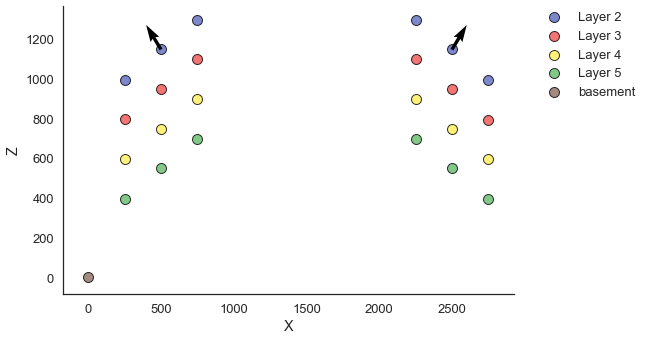

In [3]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

The input data is used to create a geologic model.

In [4]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4164' (I am process '11500')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [5]:
lith_block, fault_block = gp.compute_model(interp_data)

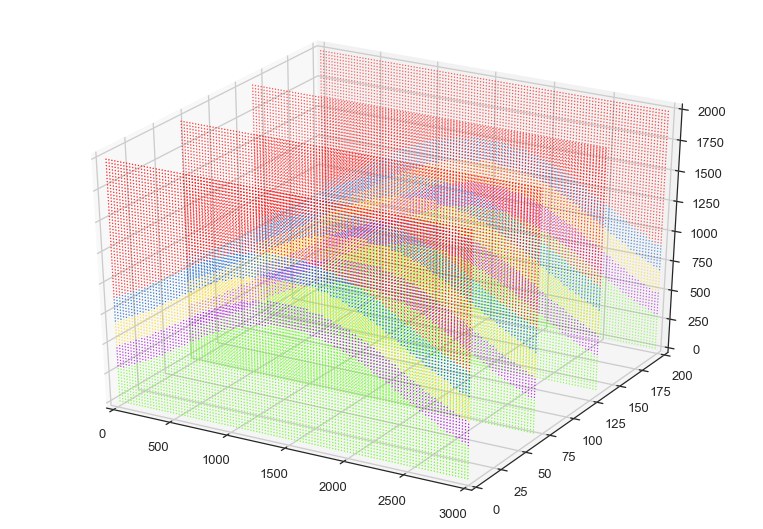

In [6]:
lith_block_int = np.round(lith_block)
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=geo_data.grid.values[:,0],ys=geo_data.grid.values[:,1],zs=geo_data.grid.values[:,2], c=lith_block_int[0], s=1, cmap='prism')

The following method provides an easy way to cut a certain part of the model. By using the lithologic model combined with the basic grid of the geologic model, it is possible to choose one lithology and create a pandas dataframe containing only the data for this seperate part of the model.

In [7]:
def init_domain (geomodel, grid, formation):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        down to a certain formation of interest.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, cut to one lith
        """
    
        # convert lith block values to int, thats what Miguel suggested
        lith_block_int = np.round(lith_block)
    
        # create the dataframe and populate with data
        d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0]}
        df_cokr = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
        df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
        del df_sgs_grid['index'] # reset indices

        return df_sgs_grid

In [8]:
domain3d = init_domain(lith_block[0], geo_data.grid, formation=3)

In [9]:
domain1d = domain3d[domain3d['Y'] < 1]  

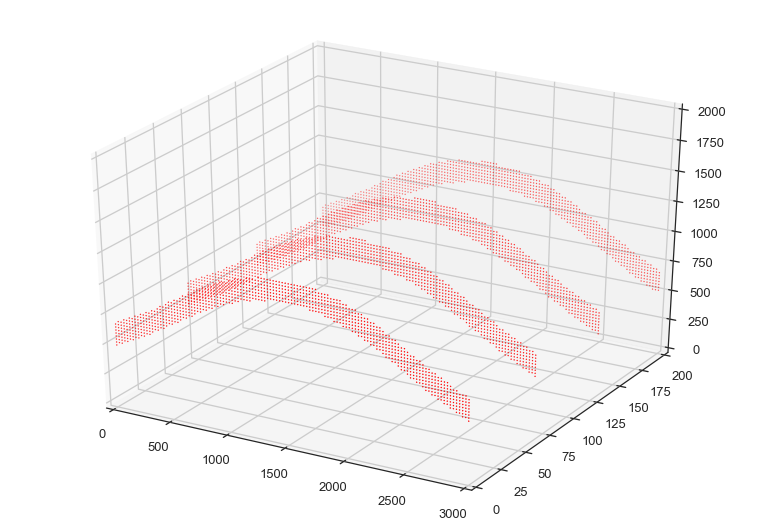

In [10]:
lith_block_int = np.round(lith_block)
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=domain3d.X,ys=domain3d.Y,zs=domain3d.Z, c='red', s=1)

In [11]:
# export data to csv file
domain3d.to_csv("domain3d.csv", index=False)

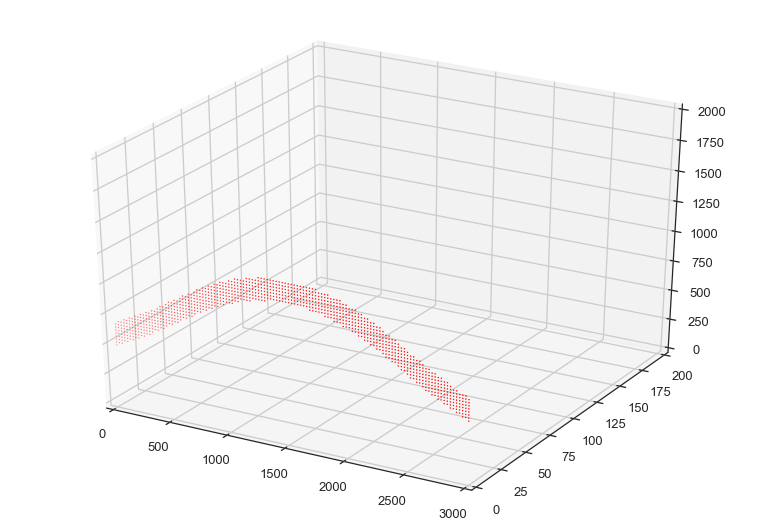

In [12]:
lith_block_int = np.round(lith_block)
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=domain1d.X,ys=domain1d.Y,zs=domain1d.Z, c='red', s=1)

In [13]:
# export data to csv file
domain1d.to_csv("domain1d.csv", index=False)